<a href="https://colab.research.google.com/github/js-iMore/Analitica_tareas/blob/master/Main_people_PCA_S_N.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Analítica de datos - ejercicio de clase lfw_people - comparación distintos métodos de clasificación con y sin PCA

Importar librerias y cargar funciones desde Google Drive

In [0]:
#Paso 1: Lectura
import os
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder
from sklearn.base import  BaseEstimator, TransformerMixin
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA 
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

#Acceso a google drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
#
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
#
file_id = '1Q-avAqJi7t_mwPSz-XvmoA38_0VsohKE' #ID del archivo en Drive
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('funciones_people.py') 
from funciones_people import pre_exploratorio, save_fig, plot_confusion_matrix, roc_multiclass, roc_auc_mc

from sklearn.impute import SimpleImputer 
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.pipeline import Pipeline
#base de datos
from sklearn.datasets import fetch_lfw_people
#https://scikit-learn.org/stable/auto_examples/applications/plot_face_recognition.html

%matplotlib inline
#descargar base de datos
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

#ejemplo imagen en base de datos
#print('Dimensiones base de datos: \n',lfw_people.images.shape)
#plt.imshow(lfw_people.images[30,:,:],cmap='gray')

#print('Clases base de datos: \n',lfw_people['target_names'])
#print(lfw_people.images[30,:,:])

Dimensiones tipo pandas:  (1288, 1850)


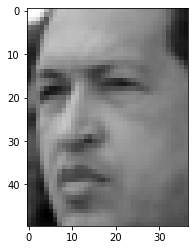

In [2]:
# datos tipo pandas
Xdata = pd.DataFrame(lfw_people.data)
y = lfw_people.target
print('Dimensiones tipo pandas: ',Xdata.shape)
plt.imshow(np.array(Xdata.iloc[0,:]).reshape(lfw_people.images.shape[1],lfw_people.images.shape[2]),cmap='gray')


In [3]:
#Paso 2: Particion entrenamiento y validacion
# Tamaño Xtrain 70%, Tamaño Xtest 30%
Xtrain, Xtest, ytrain,ytest = train_test_split(Xdata,y,test_size=0.3) #fijar en 0.3 para entrenar -- 0.95 para demostrar funcionalidad del código

Xtrain.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1810,1811,1812,1813,1814,1815,1816,1817,1818,1819,1820,1821,1822,1823,1824,1825,1826,1827,1828,1829,1830,1831,1832,1833,1834,1835,1836,1837,1838,1839,1840,1841,1842,1843,1844,1845,1846,1847,1848,1849
512,204.333328,200.000000,196.333328,192.333328,189.000000,185.333328,177.333328,180.666672,186.333328,188.333328,189.000000,194.666672,199.000000,198.666672,201.333328,203.000000,202.333328,202.000000,201.333328,199.000000,198.666672,200.000000,198.333328,200.000000,198.333328,195.000000,194.666672,193.333328,189.666672,186.666672,183.666672,182.000000,175.333328,168.000000,159.333328,158.666672,187.000000,199.333328,194.333328,189.000000,...,223.666672,211.333328,186.333328,96.666664,102.000000,101.000000,115.000000,107.666664,120.333336,132.000000,143.333328,157.666672,154.000000,125.000000,122.333336,142.333328,150.666672,157.000000,162.333328,168.333328,169.333328,164.000000,154.000000,149.666672,148.333328,147.000000,145.666672,149.666672,125.666664,106.333336,124.333336,128.000000,123.333336,166.666672,206.666672,215.000000,224.666672,226.333328,215.333328,193.333328
415,144.666672,129.666672,138.000000,174.333328,180.666672,181.000000,178.333328,178.333328,183.666672,191.000000,199.666672,203.333328,201.666672,198.666672,194.666672,191.000000,187.333328,186.666672,185.333328,183.333328,185.000000,192.333328,192.000000,190.666672,191.666672,192.666672,190.333328,183.000000,176.666672,172.333328,168.666672,159.666672,142.000000,120.333336,97.666664,89.000000,97.666664,140.333328,135.333328,160.666672,...,182.000000,192.666672,196.666672,51.333332,51.333332,47.666668,44.000000,150.000000,176.333328,172.333328,149.333328,126.000000,111.333336,96.333336,79.000000,74.333336,86.666664,101.666664,106.000000,107.000000,114.000000,115.666664,116.000000,115.333336,118.333336,123.000000,123.333336,129.333328,133.000000,125.000000,117.000000,123.000000,125.000000,122.000000,118.000000,128.000000,177.666672,185.666672,196.333328,184.333328
1075,156.000000,175.000000,179.666672,184.000000,187.000000,189.333328,194.333328,197.666672,202.333328,210.666672,217.000000,216.000000,216.333328,212.333328,212.000000,214.000000,208.000000,204.666672,201.666672,199.000000,190.666672,181.000000,171.666672,165.000000,165.666672,172.666672,170.666672,168.000000,179.666672,192.666672,203.333328,201.333328,194.666672,197.666672,191.666672,193.666672,174.000000,163.666672,170.666672,178.333328,...,74.333336,123.666664,188.333328,32.333332,29.333334,23.000000,17.000000,13.666667,8.000000,6.000000,13.333333,32.333332,56.000000,68.333336,67.333336,70.000000,72.333336,72.333336,78.333336,81.000000,77.333336,75.000000,70.333336,62.000000,51.333332,45.666668,46.000000,49.333332,51.000000,48.666668,47.000000,44.333332,45.000000,49.666668,57.000000,61.666668,66.333336,84.666664,160.666672,201.666672
79,85.666664,89.000000,83.000000,100.000000,130.666672,139.666672,140.000000,142.000000,138.666672,140.000000,136.000000,138.000000,133.333328,124.666664,117.000000,107.666664,98.333336,98.333336,99.333336,105.000000,116.000000,129.666672,139.666672,151.000000,155.666672,155.666672,154.000000,149.333328,147.666672,145.666672,145.666672,142.000000,136.333328,122.666664,79.000000,80.333336,93.666664,90.333336,89.666664,89.000000,...,220.000000,110.666664,23.666666,43.000000,32.000000,28.666666,107.333336,219.666672,227.666672,229.333328,232.000000,223.000000,171.000000,127.333336,116.000000,109.000000,103.666664,100.333336,101.333336,108.000000,114.333336,115.666664,113.333336,116.333336,119.000000,111.333336,106.333336,108.666664,110.666664,112.666664,137.333328,184.666672,219.666672,227.666672,228.333328,230.000000,228.333328,215.000000,95.333336,24.666666
389,42.333332,39.333332,37.666668,47.666668,62.000000,65.666664,71.333336,92.666664,122.666664,147.333328,162.666672,179.000000,195.333328,199.000000,207.333328,211.333328,220.000000,224.000000,222.000

[t-SNE] Computing 70 nearest neighbors...
[t-SNE] Indexed 901 samples in 0.167s...
[t-SNE] Computed neighbors for 901 samples in 3.276s...
[t-SNE] Computed conditional probabilities for sample 901 / 901
[t-SNE] Mean sigma: 15.093789
[t-SNE] Computed conditional probabilities in 0.062s
[t-SNE] Iteration 50: error = 75.0124054, gradient norm = 0.3627828 (50 iterations in 0.438s)
[t-SNE] Iteration 100: error = 74.7471008, gradient norm = 0.3345825 (50 iterations in 0.430s)
[t-SNE] Iteration 150: error = 75.1085052, gradient norm = 0.3449489 (50 iterations in 0.409s)
[t-SNE] Iteration 200: error = 76.0034180, gradient norm = 0.3292039 (50 iterations in 0.400s)
[t-SNE] Iteration 250: error = 75.2375488, gradient norm = 0.3387646 (50 iterations in 0.401s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.237549
[t-SNE] KL divergence after 251 iterations: 1797693134862315708145274237317043567980705675258449965989174768031572607800285387605895586327668781715404589535143824

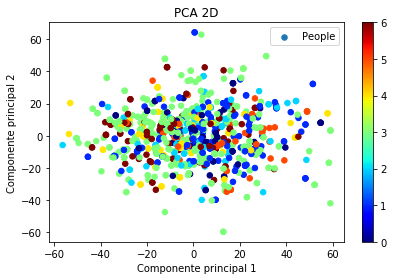

Guardando... relevancia_PCA_eigenface


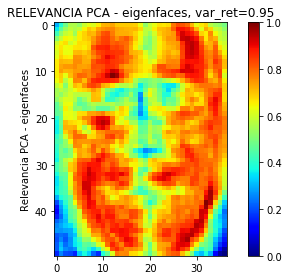

Guardando... tsne_2D


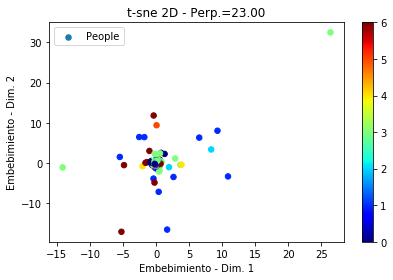

True

In [4]:
#%% Paso 3 : Analisis exploratorio
#preproceso entrada  y salida para analisis exploratorio
img_path = '' 
#para guardar 
from google.colab import files  
pre_exploratorio(Xtrain,ytrain,img_path,'People',lfw_people.images.shape[1],lfw_people.images.shape[2])

## **CLASIFICACION SIN PCA**

In [5]:
#%% Paso 4 : Escoger modelo por gridsearchCV utilizando pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.externals import joblib #https://joblib.readthedocs.io/en/latest/

steps=[
        [('cla', LogisticRegression())],
        [('cla', SGDClassifier())],
        [('cla', SVC())],
        [('cla', KNeighborsClassifier())],
        [('cla', RandomForestClassifier())],
        [('cla', GaussianNB())]
       
       #[('rep',  PCA()),
       # ('cla', SVC())]
      ]
parameters = [{              
              'cla__C': [0.5,1]
              },
              {              
              'cla__alpha': [0.0001,0.001]
              },
              {
             #'rep__n_components' : [0.8,0.9],              
             'cla__C': [0.1,1,100,500,1e3],
             'cla__gamma': [0.01, 0.1, 1,10, 100,1e3]     
             },
              {
                'cla__n_neighbors': [5]
              },
              {
                'cla__n_estimators': [50, 100, 150]
              },
              {
                'cla__var_smoothing': [1e-9, 1e-6, 1e-8] 
              }
             ]

label_models = ['Logistic','SGD', 'SVCrbf', 'KNN' , 'RandomF', 'NaiveBayes']

best_model = []
filename = 'resultados'
for i in range(len(steps)):
    print('modelo %d/%d' % (i+1,len(steps)))
    grid_search = GridSearchCV(Pipeline(steps[i]), parameters[i], n_jobs=-1,cv=5,
                                scoring='balanced_accuracy',verbose=10)
    grid_search.fit(Xtrain, ytrain)
    #print(grid_search.cv_results_)
    #mejor modelo entrenado
    best_model += [grid_search.best_estimator_]
    joblib.dump(best_model,filename+".pkl")

print('Mejores modelos sin PCA:\n')
best_model

modelo 1/6
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    9.9s finished


modelo 2/6
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.4s finished


modelo 3/6
Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   27.0s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   42.1s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   53.8s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:  4

modelo 4/6
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    1.8s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


modelo 5/6
Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   21.0s finished


modelo 6/6
Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0592s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1764s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.4s finished


Mejores modelos sin PCA:



[Pipeline(memory=None,
          steps=[('cla',
                  LogisticRegression(C=0.5, class_weight=None, dual=False,
                                     fit_intercept=True, intercept_scaling=1,
                                     l1_ratio=None, max_iter=100,
                                     multi_class='auto', n_jobs=None,
                                     penalty='l2', random_state=None,
                                     solver='lbfgs', tol=0.0001, verbose=0,
                                     warm_start=False))],
          verbose=False), Pipeline(memory=None,
          steps=[('cla',
                  SGDClassifier(alpha=0.001, average=False, class_weight=None,
                                early_stopping=False, epsilon=0.1, eta0=0.0,
                                fit_intercept=True, l1_ratio=0.15,
                                learning_rate='optimal', loss='hinge',
                                max_iter=1000, n_iter_no_change=5, n_jobs=None,
            

# Calcular rendimiento en cojunto de test

Evaluando modelo 1/6
Guardando... Logistic


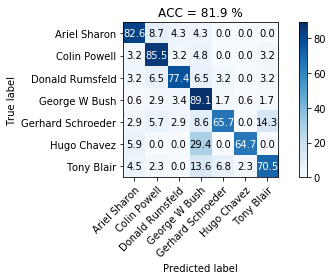

                   precision    recall  f1-score   support

     Ariel Sharon       0.70      0.83      0.76        23
     Colin Powell       0.82      0.85      0.83        62
  Donald Rumsfeld       0.71      0.77      0.74        31
    George W Bush       0.89      0.89      0.89       175
Gerhard Schroeder       0.77      0.66      0.71        35
      Hugo Chavez       0.85      0.65      0.73        17
       Tony Blair       0.74      0.70      0.72        44

         accuracy                           0.82       387
        macro avg       0.78      0.77      0.77       387
     weighted avg       0.82      0.82      0.82       387

Evaluando modelo 2/6
Guardando... SGD


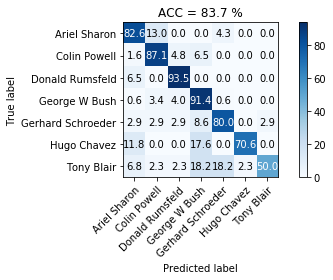

                   precision    recall  f1-score   support

     Ariel Sharon       0.66      0.83      0.73        23
     Colin Powell       0.83      0.87      0.85        62
  Donald Rumsfeld       0.71      0.94      0.81        31
    George W Bush       0.90      0.91      0.91       175
Gerhard Schroeder       0.74      0.80      0.77        35
      Hugo Chavez       0.92      0.71      0.80        17
       Tony Blair       0.96      0.50      0.66        44

         accuracy                           0.84       387
        macro avg       0.82      0.79      0.79       387
     weighted avg       0.85      0.84      0.83       387

Evaluando modelo 3/6
Guardando... SVCrbf


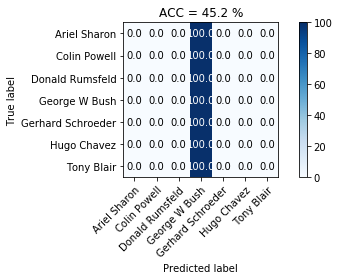

                   precision    recall  f1-score   support

     Ariel Sharon       0.00      0.00      0.00        23
     Colin Powell       0.00      0.00      0.00        62
  Donald Rumsfeld       0.00      0.00      0.00        31
    George W Bush       0.45      1.00      0.62       175
Gerhard Schroeder       0.00      0.00      0.00        35
      Hugo Chavez       0.00      0.00      0.00        17
       Tony Blair       0.00      0.00      0.00        44

         accuracy                           0.45       387
        macro avg       0.06      0.14      0.09       387
     weighted avg       0.20      0.45      0.28       387

Evaluando modelo 4/6
Guardando... KNN


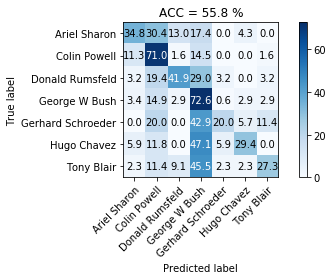

                   precision    recall  f1-score   support

     Ariel Sharon       0.33      0.35      0.34        23
     Colin Powell       0.45      0.71      0.55        62
  Donald Rumsfeld       0.50      0.42      0.46        31
    George W Bush       0.66      0.73      0.69       175
Gerhard Schroeder       0.64      0.20      0.30        35
      Hugo Chavez       0.36      0.29      0.32        17
       Tony Blair       0.52      0.27      0.36        44

         accuracy                           0.56       387
        macro avg       0.49      0.42      0.43       387
     weighted avg       0.56      0.56      0.54       387

Evaluando modelo 5/6
Guardando... RandomF


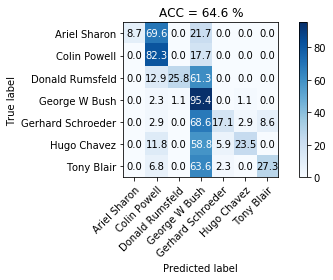

                   precision    recall  f1-score   support

     Ariel Sharon       1.00      0.09      0.16        23
     Colin Powell       0.63      0.82      0.71        62
  Donald Rumsfeld       0.80      0.26      0.39        31
    George W Bush       0.63      0.95      0.76       175
Gerhard Schroeder       0.75      0.17      0.28        35
      Hugo Chavez       0.57      0.24      0.33        17
       Tony Blair       0.80      0.27      0.41        44

         accuracy                           0.65       387
        macro avg       0.74      0.40      0.43       387
     weighted avg       0.69      0.65      0.59       387

Evaluando modelo 6/6
Guardando... NaiveBayes


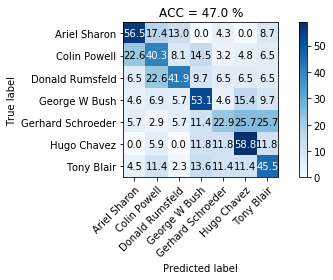

                   precision    recall  f1-score   support

     Ariel Sharon       0.32      0.57      0.41        23
     Colin Powell       0.45      0.40      0.43        62
  Donald Rumsfeld       0.38      0.42      0.40        31
    George W Bush       0.79      0.53      0.64       175
Gerhard Schroeder       0.29      0.23      0.25        35
      Hugo Chavez       0.18      0.59      0.27        17
       Tony Blair       0.36      0.45      0.40        44

         accuracy                           0.47       387
        macro avg       0.40      0.46      0.40       387
     weighted avg       0.56      0.47      0.49       387



In [6]:
#%% Paso 5: evaluar sobre Xtest
my_model_loaded = joblib.load(filename+".pkl")
path_img = ''
for i in range(len(my_model_loaded)):
    print('Evaluando modelo %d/%d' % (i+1,len(my_model_loaded)))

    ytest_e = my_model_loaded[i].predict(Xtest)
    acc = accuracy_score(ytest,ytest_e)
     
    plot_confusion_matrix(
                          ytest, ytest_e, 
                          classes=lfw_people.target_names,
                          normalize=True,
                          title='ACC = %.1f %%' % (100*acc)
                          )
    plt.autoscale()
    save_fig(path_img,label_models[i])                      
    plt.show()
    
    cr = classification_report(
                               ytest, ytest_e, 
                               labels=range(lfw_people.target_names.shape[0]),
                               target_names=lfw_people.target_names
                               )                          
    #support = #muestras en la clase estudiada
    print(cr)


## Curva ROC multiclase - sobre conjunto de test

Evaluando ROC modelo 1/6
Guardando... ROC curve Logistic


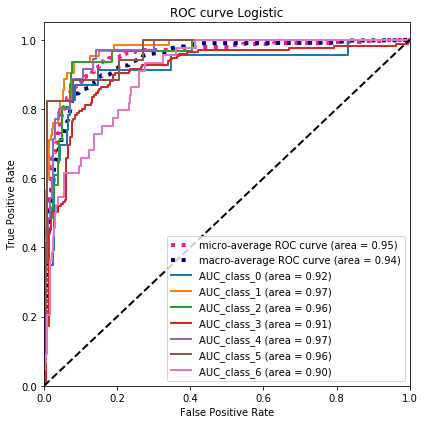

Evaluando ROC modelo 2/6
Guardando... ROC curve SGD


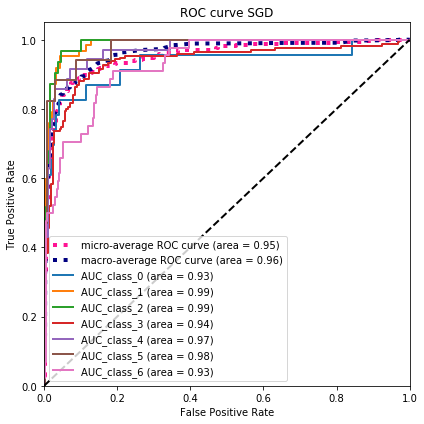

Evaluando ROC modelo 3/6
Guardando... ROC curve SVCrbf


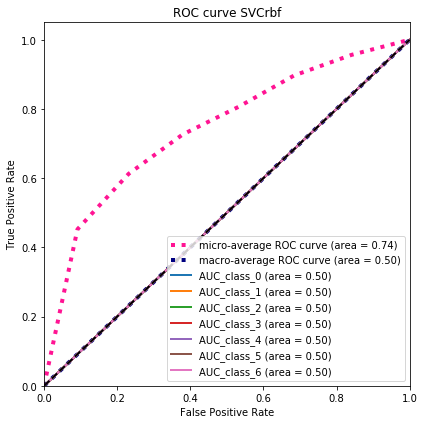

Evaluando ROC modelo 4/6
Guardando... ROC curve KNN


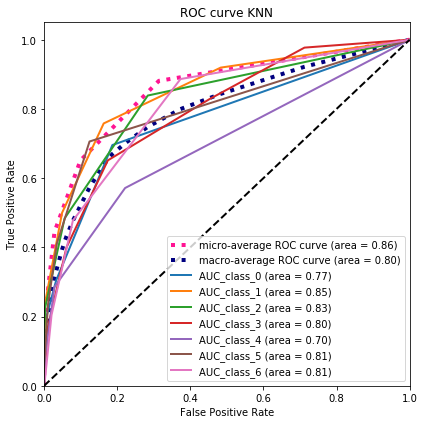

Evaluando ROC modelo 5/6
Guardando... ROC curve RandomF


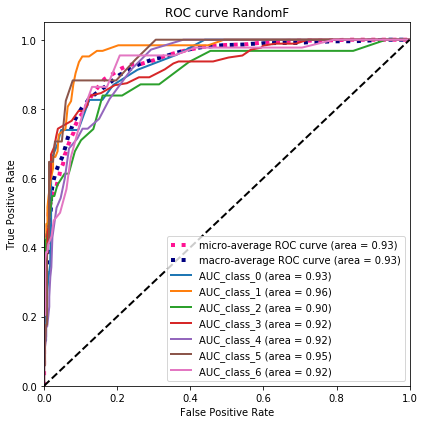

Evaluando ROC modelo 6/6
Guardando... ROC curve NaiveBayes


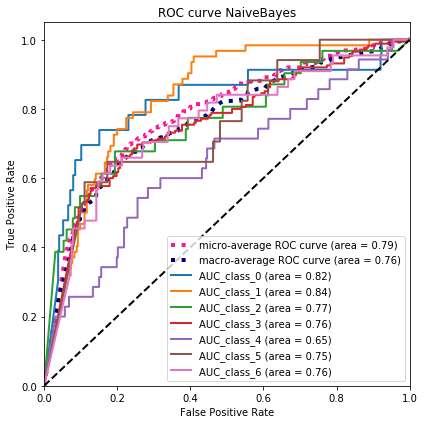

In [7]:
from sklearn.preprocessing import label_binarize

ytrain_b = label_binarize(ytrain, classes=range(lfw_people.target_names.shape[0]))
ytest_b = label_binarize(ytest, classes=range(lfw_people.target_names.shape[0]))
#label_models[i]
for i in range(len(my_model_loaded)):
    print('Evaluando ROC modelo %d/%d' % (i+1,len(my_model_loaded)))
    if label_models[i] == 'KNN' or label_models[i] == 'RandomF' or label_models[i] =='NaiveBayes':
      ytest_score = my_model_loaded[i].predict_proba(Xtest) #debe calcularse la funcion de decision o el posterior de la probabilidad
      roc_auc, fpr, tpr, n_classes = roc_multiclass(ytest_b,ytest_score)
      roc_auc_mc(roc_auc,fpr,tpr,n_classes,'ROC curve ' + label_models[i],path_img)

    else:
      ytest_score = my_model_loaded[i].decision_function(Xtest) #debe calcularse la funcion de decision o el posterior de la probabilidad
      roc_auc, fpr, tpr, n_classes = roc_multiclass(ytest_b,ytest_score)
      roc_auc_mc(roc_auc,fpr,tpr,n_classes,'ROC curve ' + label_models[i],path_img)

    
    

## **CLASIFICACIÓN CON PCA**

In [8]:
steps=[
       [('rep',  PCA()),
        ('cla', LogisticRegression())],
      [('rep',  PCA()),
        ('cla', SGDClassifier())],
       [('rep',  PCA()), 
        ('cla', SVC())],
       [('rep',  PCA()),
        ('cla', KNeighborsClassifier())],
       [('rep',  PCA()), 
        ('cla', RandomForestClassifier())],
      [('rep',  PCA()),
        ('cla', GaussianNB())]

      ]
parameters = [{
              'rep__n_components' : [0.8,0.9],              
              'cla__C': [0.5,1]
              },
              {              
              'rep__n_components' : [0.8,0.9],    
              'cla__alpha': [0.0001,0.001]
              },
              {
             'rep__n_components' : [0.8,0.9],              
             'cla__C': [0.1,1,100,500,1e3],
             'cla__gamma': [0.01, 0.1, 1,10, 100,1e3]     
             },
              {
                'rep__n_components' : [0.8,0.9],
                'cla__n_neighbors': [5]
              },
              {
                'rep__n_components' : [0.8,0.9],
                'cla__n_estimators': [50, 100, 150]
              },
              {
                'rep__n_components' : [0.8,0.9],
                'cla__var_smoothing': [1e-9, 1e-6, 1e-8] 
              }
             ]

label_models2 = ['PCA_Logistic','PCA_SGD', 'PCA_SVCrbf', 'PCA_KNN' , 'PCA_RandomF', 'PCA_NaiveBayes']

best_model2 = []
filename2 = 'resultadosPCA'
for i in range(len(steps)):
    print('modelo %d/%d' % (i+1,len(steps)))
    grid_search = GridSearchCV(Pipeline(steps[i]), parameters[i], n_jobs=-1,cv=5,
                                scoring='balanced_accuracy',verbose=10)
    grid_search.fit(Xtrain, ytrain)
    #print(grid_search.cv_results_)
    #mejor modelo entrenado
    best_model2 += [grid_search.best_estimator_]
    joblib.dump(best_model2,filename2+".pkl")

print('Mejores modelos con PCA:\n')
best_model2

modelo 1/6
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    8.6s finished
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    8.6s remaining:    0.0s


modelo 2/6
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    8.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    8.1s finished


modelo 3/6
Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   29.6s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   35.0s
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   40.7s
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:   47.2s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   54.0s
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:  1

modelo 4/6
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.7s finished


modelo 5/6
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   20.7s finished


modelo 6/6
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   10.6s finished


Mejores modelos con PCA:



[Pipeline(memory=None,
          steps=[('rep',
                  PCA(copy=True, iterated_power='auto', n_components=0.9,
                      random_state=None, svd_solver='auto', tol=0.0,
                      whiten=False)),
                 ('cla',
                  LogisticRegression(C=0.5, class_weight=None, dual=False,
                                     fit_intercept=True, intercept_scaling=1,
                                     l1_ratio=None, max_iter=100,
                                     multi_class='auto', n_jobs=None,
                                     penalty='l2', random_state=None,
                                     solver='lbfgs', tol=0.0001, verbose=0,
                                     warm_start=False))],
          verbose=False), Pipeline(memory=None,
          steps=[('rep',
                  PCA(copy=True, iterated_power='auto', n_components=0.9,
                      random_state=None, svd_solver='auto', tol=0.0,
                      whiten=False)),

Evaluando modelo 1/6
Guardando... PCA_Logistic


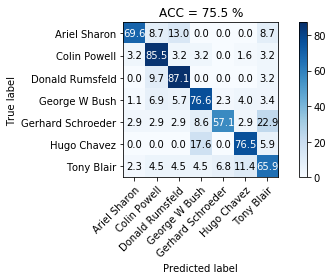

                   precision    recall  f1-score   support

     Ariel Sharon       0.73      0.70      0.71        23
     Colin Powell       0.73      0.85      0.79        62
  Donald Rumsfeld       0.60      0.87      0.71        31
    George W Bush       0.93      0.77      0.84       175
Gerhard Schroeder       0.74      0.57      0.65        35
      Hugo Chavez       0.48      0.76      0.59        17
       Tony Blair       0.59      0.66      0.62        44

         accuracy                           0.75       387
        macro avg       0.69      0.74      0.70       387
     weighted avg       0.78      0.75      0.76       387

Evaluando modelo 2/6
Guardando... PCA_SGD


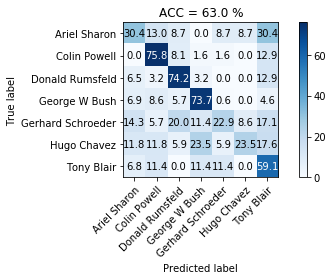

                   precision    recall  f1-score   support

     Ariel Sharon       0.23      0.30      0.26        23
     Colin Powell       0.63      0.76      0.69        62
  Donald Rumsfeld       0.48      0.74      0.58        31
    George W Bush       0.90      0.74      0.81       175
Gerhard Schroeder       0.44      0.23      0.30        35
      Hugo Chavez       0.44      0.24      0.31        17
       Tony Blair       0.42      0.59      0.49        44

         accuracy                           0.63       387
        macro avg       0.51      0.51      0.49       387
     weighted avg       0.66      0.63      0.63       387

Evaluando modelo 3/6
Guardando... PCA_SVCrbf


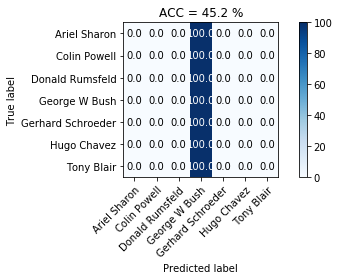

                   precision    recall  f1-score   support

     Ariel Sharon       0.00      0.00      0.00        23
     Colin Powell       0.00      0.00      0.00        62
  Donald Rumsfeld       0.00      0.00      0.00        31
    George W Bush       0.45      1.00      0.62       175
Gerhard Schroeder       0.00      0.00      0.00        35
      Hugo Chavez       0.00      0.00      0.00        17
       Tony Blair       0.00      0.00      0.00        44

         accuracy                           0.45       387
        macro avg       0.06      0.14      0.09       387
     weighted avg       0.20      0.45      0.28       387

Evaluando modelo 4/6
Guardando... PCA_KNN


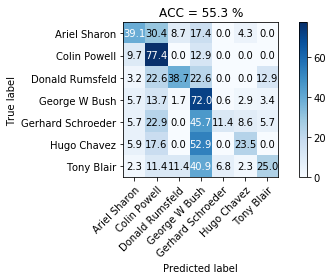

                   precision    recall  f1-score   support

     Ariel Sharon       0.30      0.39      0.34        23
     Colin Powell       0.47      0.77      0.59        62
  Donald Rumsfeld       0.55      0.39      0.45        31
    George W Bush       0.67      0.72      0.69       175
Gerhard Schroeder       0.50      0.11      0.19        35
      Hugo Chavez       0.29      0.24      0.26        17
       Tony Blair       0.48      0.25      0.33        44

         accuracy                           0.55       387
        macro avg       0.46      0.41      0.41       387
     weighted avg       0.55      0.55      0.53       387

Evaluando modelo 5/6
Guardando... PCA_RandomF


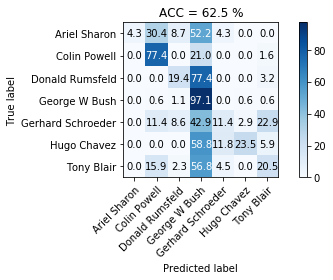

                   precision    recall  f1-score   support

     Ariel Sharon       1.00      0.04      0.08        23
     Colin Powell       0.72      0.77      0.74        62
  Donald Rumsfeld       0.43      0.19      0.27        31
    George W Bush       0.63      0.97      0.77       175
Gerhard Schroeder       0.44      0.11      0.18        35
      Hugo Chavez       0.67      0.24      0.35        17
       Tony Blair       0.43      0.20      0.28        44

         accuracy                           0.63       387
        macro avg       0.62      0.36      0.38       387
     weighted avg       0.61      0.63      0.56       387

Evaluando modelo 6/6
Guardando... PCA_NaiveBayes


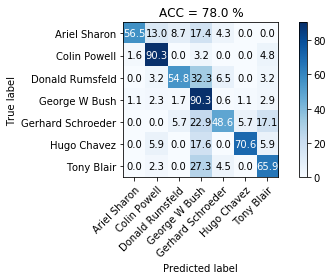

                   precision    recall  f1-score   support

     Ariel Sharon       0.81      0.57      0.67        23
     Colin Powell       0.85      0.90      0.88        62
  Donald Rumsfeld       0.71      0.55      0.62        31
    George W Bush       0.80      0.90      0.85       175
Gerhard Schroeder       0.74      0.49      0.59        35
      Hugo Chavez       0.75      0.71      0.73        17
       Tony Blair       0.64      0.66      0.65        44

         accuracy                           0.78       387
        macro avg       0.76      0.68      0.71       387
     weighted avg       0.78      0.78      0.77       387



In [9]:
my_model_loaded2 = joblib.load(filename2+".pkl")
path_img = ''
for i in range(len(my_model_loaded2)):
    print('Evaluando modelo %d/%d' % (i+1,len(my_model_loaded2)))

    ytest_e = my_model_loaded2[i].predict(Xtest)
    acc = accuracy_score(ytest,ytest_e)
     
    plot_confusion_matrix(
                          ytest, ytest_e, 
                          classes=lfw_people.target_names,
                          normalize=True,
                          title='ACC = %.1f %%' % (100*acc)
                          )
    plt.autoscale()
    save_fig(path_img,label_models2[i])                      
    plt.show()
    
    cr2 = classification_report(
                               ytest, ytest_e, 
                               labels=range(lfw_people.target_names.shape[0]),
                               target_names=lfw_people.target_names
                               )                          
    #support = #muestras en la clase estudiada
    print(cr2)

Evaluando ROC modelo 1/6
Guardando... ROC curve Logistic


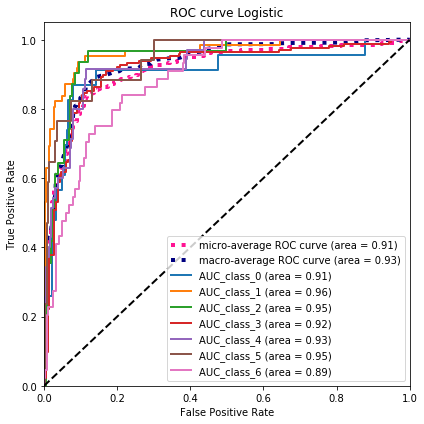

Evaluando ROC modelo 2/6
Guardando... ROC curve SGD


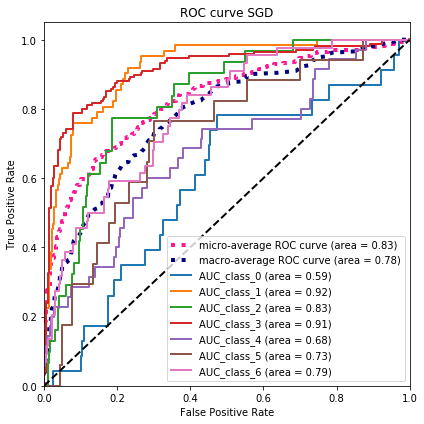

Evaluando ROC modelo 3/6
Guardando... ROC curve SVCrbf


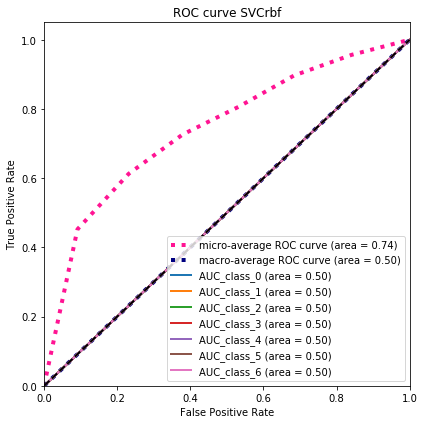

Evaluando ROC modelo 4/6
Guardando... ROC curve KNN


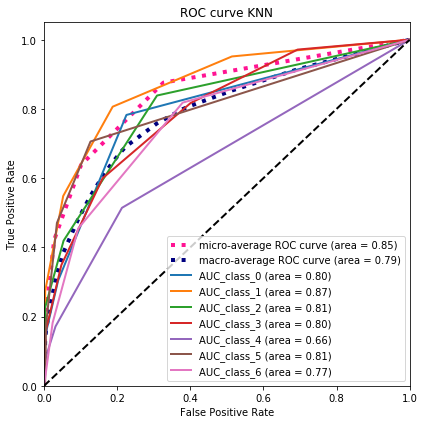

Evaluando ROC modelo 5/6
Guardando... ROC curve RandomF


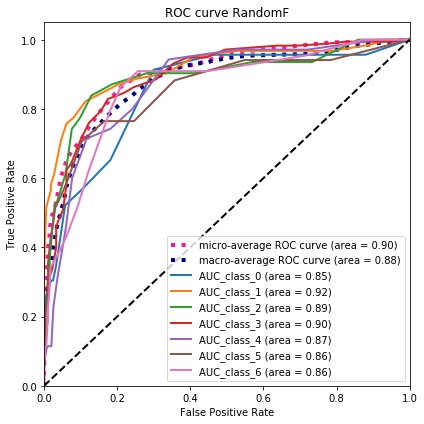

Evaluando ROC modelo 6/6
Guardando... ROC curve NaiveBayes


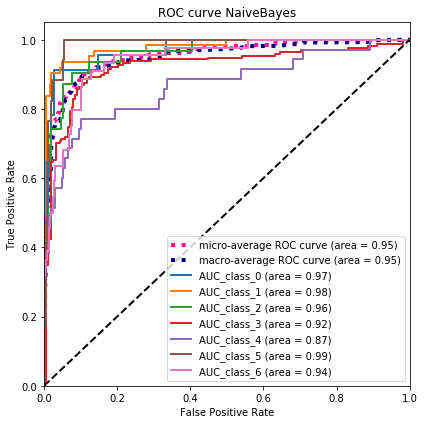

In [10]:
from sklearn.preprocessing import label_binarize

ytrain_b = label_binarize(ytrain, classes=range(lfw_people.target_names.shape[0]))
ytest_b = label_binarize(ytest, classes=range(lfw_people.target_names.shape[0]))
#label_models[i]
for i in range(len(my_model_loaded2)):
    print('Evaluando ROC modelo %d/%d' % (i+1,len(my_model_loaded2)))
    if label_models2[i] == 'PCA_KNN' or label_models2[i] == 'PCA_RandomF' or label_models2[i] =='PCA_NaiveBayes':
      ytest_score = my_model_loaded2[i].predict_proba(Xtest) #debe calcularse la funcion de decision o el posterior de la probabilidad
      roc_auc, fpr, tpr, n_classes = roc_multiclass(ytest_b,ytest_score)
      roc_auc_mc(roc_auc,fpr,tpr,n_classes,'ROC curve ' + label_models[i],path_img)

    else:
      ytest_score = my_model_loaded2[i].decision_function(Xtest) #debe calcularse la funcion de decision o el posterior de la probabilidad
      roc_auc, fpr, tpr, n_classes = roc_multiclass(ytest_b,ytest_score)
      roc_auc_mc(roc_auc,fpr,tpr,n_classes,'ROC curve ' + label_models[i],path_img)